In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd

# Read the CSV file
titanic_data = pd.read_csv('dataset/titanic.csv')

# Rename the data to a dataframe for semantics
df = titanic_data

# Let's see what the attribute values are:
print(df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [18]:
# First thing we need to do is to clean the data to prepare it for PCA. Remember, PCA works on numerical data, 
# whilst most of the attributes below are qualitative.
# Drop columns that are not useful for PCA or have too many missing values
df_clean = df.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'])

# Probably better ways to do this, but for now imma just drop the rows with missing values
df_clean = df_clean.dropna()

# Convert categorical variables into dummy/indicator variables
# Converts a category attribute like sex and embarked into a binary attribute. This creates a column sex_male and drops sex_female as
# it's redundant, either its true or not. Embarked has value S, C or Q so it creates embarked q and s, dropping embarked c as it's redundant,
# done by drop_first=true.
df_clean = pd.get_dummies(df_clean, columns=['Sex', 'Embarked'], drop_first=True)

# Let's see how the dataset looks like now:
print(df_clean.head())

   Survived  Pclass   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  \
0         0       3  22.0      1      0   7.2500      True       False   
1         1       1  38.0      1      0  71.2833     False       False   
2         1       3  26.0      0      0   7.9250     False       False   
3         1       1  35.0      1      0  53.1000     False       False   
4         0       3  35.0      0      0   8.0500      True       False   

   Embarked_S  
0        True  
1       False  
2        True  
3        True  
4        True  


In [19]:
# The attributes above are of interest when it comes to the target variable being survivability and we can see that we have no more 
# missing attributes that are not numerical.

# One last thing before we apply PCA, we need to standardize the data. This is because PCA is sensitive to the scale of the data.
# One reason is that if we compare age to fare, age can vary from 0 to 100, whilst fare can vary from 0 to 1000. This means that
# the variance in the data is dominated by fare. We need to standardize the data so that the variance in the data is not dominated
# by one attribute. We can do this by subtracting the mean and dividing by the standard deviation of each attribute! 

# Standardize the data using the StandardScaler import, mathematically this is fairly simple, as it involves Z scoring the data
# with Z = (X - myu) / sigma. This forms the basis of a normal distribution.
scaler = StandardScaler()
# fit calculates the mean and standard deviation of each attribute and transform applies the Z score formula to each attribute.
df_standardized = scaler.fit_transform(df_clean)

# Let's see how it looks like now:
print(df_standardized)

[[-0.82416338  0.90859974 -0.52766856 ...  0.75613751 -0.20232566
   0.53403984]
 [ 1.21335165 -1.48298257  0.57709388 ... -1.32251077 -0.20232566
  -1.87251946]
 [ 1.21335165  0.90859974 -0.25147795 ... -1.32251077 -0.20232566
   0.53403984]
 ...
 [ 1.21335165 -1.48298257 -0.73481151 ... -1.32251077 -0.20232566
   0.53403984]
 [ 1.21335165 -1.48298257 -0.25147795 ...  0.75613751 -0.20232566
  -1.87251946]
 [-0.82416338  0.90859974  0.16280796 ...  0.75613751  4.94252683
  -1.87251946]]


In [26]:
# All the values above show how many standard deviations away from the mean the data is. Notice how there's one value that is 4.94
# standard deviations away from the mean. This is an outlier that we should take into account when we do PCA.

# Another thing to note is that by standardizing the data, we don't need to do
# Y = df_standardized - np.mean(df_standardized, axis=0) anymore because standardizing already transforms the attribute so that the mean is 0.

# Let's finally perform PCA via Single Value Decomposition svd:
U, S, Vt = svd(df_standardized, full_matrices=False)

# Compute variance explained by principal components
# For example: if S is [3, 2, 1] then S * S is [9, 4, 1] and (S * S).sum() is 9 + 4 + 1 = 14.
# rho is [9/14, 4/14, 1/14] = [0.64, 0.29, 0.07] where we get the variance explained by each principal component!
rho = (S * S) / (S * S).sum()

# Let's see how much variance is explained by the first 3 principal components:
print("The first principal component explains", rho[0] * 100, "% of the variance.")
print("The second principal component explains", rho[1] * 100, "% of the variance.")
print("The third principal component explains", rho[2] * 100, "% of the variance.")


The first principal component explains 24.6113851183069 % of the variance.
The second principal component explains 19.487247916098706 % of the variance.
The third principal component explains 15.066051913553114 % of the variance.


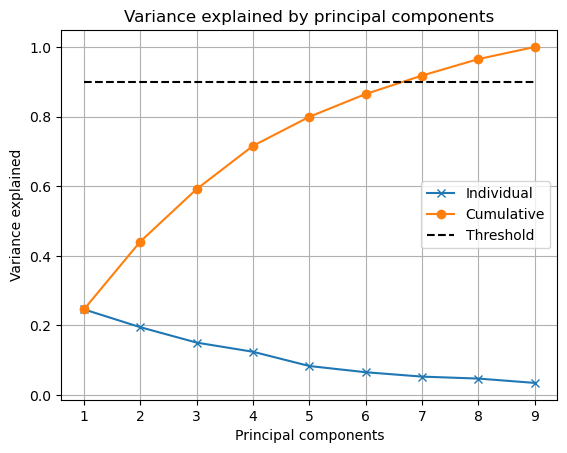

In [33]:
# We can see that the first three principle components are ordered from highest to lowest variance explained.
# Usually we want to define a threshold, which in our case will be 90% of the variance explained.

threshold = 0.9

# Let's try to visualize this better via plots:
plt.figure()
# First plot shows the variance explained by each principal component
plt.plot(range(1, len(rho) + 1), rho, "x-")
# Second will show the cumulative variance explained by the principal components
plt.plot(range(1, len(rho) + 1), np.cumsum(rho), "o-")
# Let's now add the threshold
plt.plot([1, len(rho)], [threshold, threshold], "k--")
# Add a title
plt.title("Variance explained by principal components")
# Label the axis
plt.xlabel("Principal components")
plt.ylabel("Variance explained")
# Add legend and grid as visual aid
plt.legend(["Individual", "Cumulative", "Threshold"])
plt.grid()

In [ ]:
# How can we interpret this result? It's obvious from the graph above that we need at least 7 principal components to explain at least 90% of the variance,
# which is 2 less dimensions than the cleaned dataset and 6 less dimensions than the original dataset. This is a reduction in dimensionality whilst still
# being able to explain most of the spread of the original data!
